# Projet MLBIO : Classification de type de cancer de la peau - pytorch
Caroline Devaux  
Emmanuel Mollard  
SCIA 2023   
    
    Compléter et mettre le sujet en détail ici

## I. Importation des données

In [ ]:
import kaggle
import json

kaggle.api.authenticate()

kaggle.api.dataset_download_files('surajghuwalewala/ham1000-segmentation-and-classification', path='data/', unzip=True)

In [156]:
import pandas as pd
data = pd.read_csv('data/GroundTruth.csv')

## II. Etude du dataset

Tout d'abord nous allons étudier la répartition des différentes catégories du dataset. Nous pouvons observer 7 différents types de mélanome, les plus présents dans le dataset sont le **Melanocytic nevi (NV)**, le **Mélanome (MEL)** et le **Benign keratosis lesions (BKL)**.

In [157]:
data.sum(axis=0)

image    ISIC_0024306ISIC_0024307ISIC_0024308ISIC_00243...
MEL                                                 1113.0
NV                                                  6705.0
BCC                                                  514.0
AKIEC                                                327.0
BKL                                                 1099.0
DF                                                   115.0
VASC                                                 142.0
dtype: object

Ici nous avons une description en pourcentage de la distribution pour chaque classe.

In [158]:
data.describe().loc['mean':'std']

,MEL,NV,BCC,AKIEC,BKL,DF,VASC
mean,0.111133,0.669496,0.051323,0.032651,0.109735,0.011483,0.014179
std,0.314313,0.470418,0.220667,0.177730,0.312575,0.106546,0.118233


Le dataset ne possède pas de valeur qui soit dupliquée nous n'aurons pas a faire un prétraitement à ce niveau.

In [159]:
data.duplicated().sum()

0

## III. Préparation de données

In [160]:
import numpy as np

In [161]:
data_labels = []
data_labels_i = []
labels = list(data.columns[1:])
for i in range (len(data)):
    row= np.argmax(list(data.iloc[i])[1:])
    data_labels.append(labels[row])
    data_labels_i.append(row)
data['label'] = data_labels
data['label_idx'] = data_labels_i
data['image'] = data["image"] + '.jpg'
data = data.drop(columns=labels)
data

,image,label,label_idx
0,ISIC_0024306.jpg,NV,1
1,ISIC_0024307.jpg,NV,1
2,ISIC_0024308.jpg,NV,1
3,ISIC_0024309.jpg,NV,1
4,ISIC_0024310.jpg,MEL,0
...,...,...,...
10010,ISIC_0034316.jpg,MEL,0
10011,ISIC_0034317.jpg,MEL,0
10012,ISIC_0034318.jpg,BKL,4
10013,ISIC_0034319.jpg,NV,1


In [162]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('data/images/') if isfile(join('data/images/', f))]
name_images = onlyfiles[1:]

In [163]:
from sklearn.model_selection import train_test_split
train_split=.9 # set this to the percentof the data you want to use for training
valid_split=.03 # set this to the percent of the data you want to use for validation
# Note percent of data sed for test is 1-train_split-valid_split

valid_split=valid_split/(1-train_split)
train_test_split
train_df, val_test_df = train_test_split(data, train_size=train_split, random_state=62)
val_df, test_df = train_test_split(val_test_df, train_size=valid_split, random_state=62)
print('Data Len Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))

Data Len Train: 9013 Val: 300 Test: 702


### Equilibre du jeu de donnée ?
Le dataset que nous avons est fortement déséquilibré, la classe NV est présente en majorité, cela peut nous poser un problème pour l'accuracy de notre modèle. Nous avons plusiseurs solutions disponibles qui cependant peuvent dépendre du contexte, ici nous sommes dans un contexte où la donnée la plus présente représente le mélanome le plus retrouvé, c'est une information qui peut être intéressante à considérer.

- Une méthode peut être de regrouper dans la classification d'un premier modèle des mélanomes avec moins de données en entrées et les reclassifier spécifiquement dans une second modèle.

- Il peut etre intéressant d'utilisé un modèle de pénalité, qui pénalise fortement le modèle quand il a mal classifier une classe minoritaire.

- On peut également utiliser undersampling, réajuster une des classes majoritaire pour qu'elle soit plus proche de la quantité des classes minoritaire (utile pour dataset >10k ce qui est un peu notre cas)

- Oversampling, ajouter dupliquer en modifiant un peu les iamges minoritaire pour ajouter de la quantité

- class weights permets de prendre en compte le caractère biaisé de la distribution du dataset et de créer un modèle pénalisé. Il s’agit ici de simplement attribuer des poids différents aux différentes classes de notre dataset, en donnant un poids plus important aux classes minoritaires, afin d’influencer le modèle lors de son entraînement. Nous pénalisons ainsi plus fortement une erreur de classification d’une classe minoritaire par rapport à une erreur de classification d’une classe majoritaire.



Dans notre contexte, il faut surveiller les caractéristiques pour chaque classe à ne pas diminuer pour que la reconnaissance ne soit pas biaisée. Dans un premier temps :
La « règle ABCDE » peut aider à reconnaître les signes d’alerte d’un mélanome :

    - A comme Asymétrie : le grain de beauté n'est pas régulier, ni rond, ni oval et ses reliefs ne sont pas répartis régulièrement autour de son centre,
    - B comme Bords irréguliers : ses bords sont irréguliers et mal délimités,
    - C comme Couleur : il présente plusieurs couleurs : noir, bleu, marron, rouge ou blanc,
    - D comme Diamètre : il est de grande taille (plus de 6 mm),
    - E comme Évolution : il évolue et grossit, change d'épaisseur et de couleur.


#### A. Undersampling
On va faire plusieurs mini groupe random de train avec seulement 400 données environ maximum

In [164]:
max_size=450 # set maximum number of samples for each class
samples=[]
group=train_df.groupby('label')
for label in train_df['label'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['label'].value_counts())    
    if count>=max_size:
        sample=Lgroup.sample(max_size, axis=0)        
    else:        
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample) 
train_df=pd.concat(samples, axis=0).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(train_df['label'].value_counts())

NV       450
BKL      450
BCC      450
MEL      450
AKIEC    286
VASC     128
DF       101
Name: label, dtype: int64


Pour mieux voir la répartition nous avons choisi d'observer également grâce à une pie. Dans la partie suivante, nous allons rééquilibrer le dataset pour qu'il y ait un meilleur équilibre.

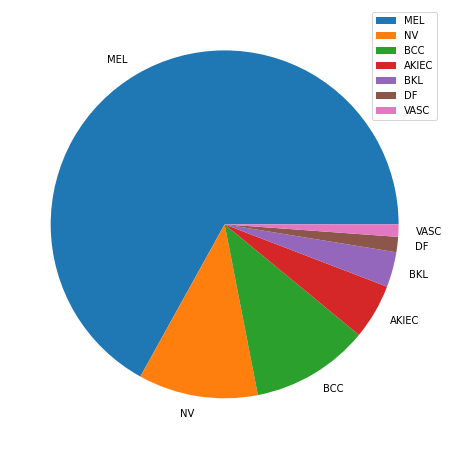

In [165]:
pourcentages = data['label'].value_counts() / len(data)
from matplotlib import pyplot
pyplot.figure(figsize = (8, 8))
pyplot.pie(pourcentages, labels=labels, normalize = False)
pyplot.legend()

In [166]:
new_pourcentages = train_df['label'].value_counts() / len(train_df)
new_pourcentages

NV       0.194384
BKL      0.194384
BCC      0.194384
MEL      0.194384
AKIEC    0.123542
VASC     0.055292
DF       0.043629
Name: label, dtype: float64

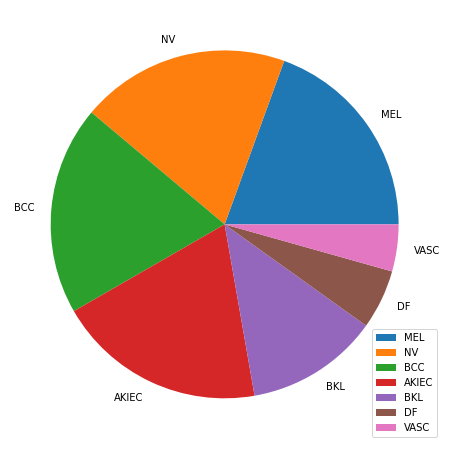

In [167]:
from matplotlib import pyplot
pyplot.figure(figsize = (8, 8))
pyplot.pie(new_pourcentages, labels=labels, normalize = False)
pyplot.legend()

#### B. Oversampling

In [168]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [169]:
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20)])
                                        # transforms.ToTensor(), 
                                        # transforms.Normalize(norm_mean, norm_std)])#Normalisation des données

# # define the transformation of the val and test images.
# val_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
#                                     transforms.Normalize(norm_mean, norm_std)])

In [171]:
import torch
import os
class SkinClassification(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(os.path.join('data/', 'images', self.df['image'][index]))
        y = torch.tensor(int(self.df['label_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [207]:
BATCH_SIZE = 4
NUM_WORKERS = 2

# Define the training,val,test sets using the tables and using our defined transitions
train_set = SkinClassification(train_df, transforms=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print('Data Len Train:', len(train_set))

Data Len Train: 2315


In [208]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [209]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [210]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: DataLoader worker (pid(s) 10788, 1460) exited unexpectedly

In [83]:
from PIL import Image

In [84]:
img = Image.open('data/images/ISIC_0024306.jpg')

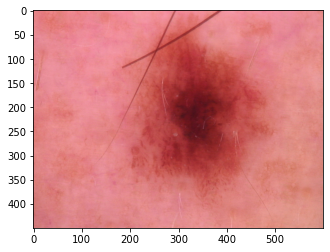

In [31]:
import matplotlib.pyplot as plt
plt.imshow(img)

Text(0.5, 1.0, 'distribution of pixels')

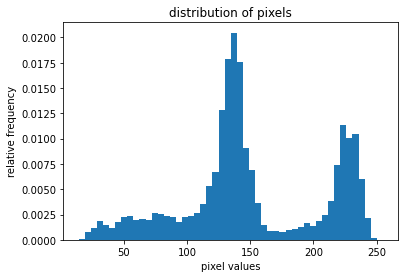

In [36]:
img_np = np.array(img)

# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

Text(0.5, 1.0, 'distribution of pixels')

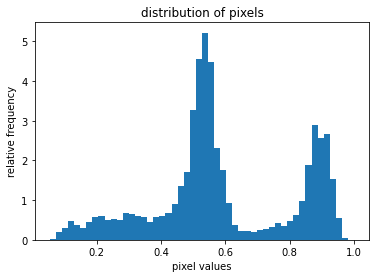

In [37]:
# Python code for converting PIL Image to
# PyTorch Tensor image and plot pixel values

# import necessary libraries
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# define custom transform function
transform = transforms.Compose([
    transforms.ToTensor()
])

# transform the pIL image to tensor
# image
img_tr = transform(img)

# Convert tensor image to numpy array
img_np = np.array(img_tr)

# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

In [39]:
# Python code to calculate mean and std
# of image

# get tensor image
img_tr = transform(img)

# calculate mean and std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.8421, 0.4613, 0.4645])
Std of the image: tensor([0.1098, 0.1282, 0.1326])


Text(0.5, 1.0, 'distribution of pixels')

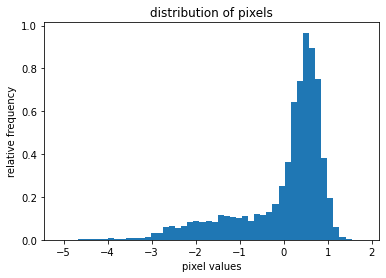

In [40]:
from torchvision import transforms

# define custom transform
# here we are using our calculated
# mean & std
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# get normalized image
img_normalized = transform_norm(img)

# convert normalized image to numpy
# array
img_np = np.array(img_normalized)

# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

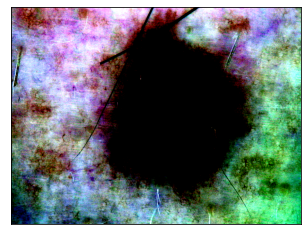

In [41]:
# Python Code to visualize normalized image

# get normalized image
img_normalized = transform_norm(img)

# convert this image to numpy array
img_normalized = np.array(img_normalized)

# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)

# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])

In [46]:
import pandas as pd
df = pd.read_csv("data/GroundTruth.csv")

TypeError: __init__() missing 1 required positional argument: 'loader'

## 4. Modèle numéro 1

## 5. Modèle nnuméro 2

## 6. Comparaison des résulats